# **Тематическое моделирование сообщений с форума Reddit с помощью библиотеки BERTopic**

Этот проект позволяет:

1. Получить данные из Reddit
2. Очистить полученные данные
3. Извлечь главные обсуждаемые темы из обсуждений
4. Сохранить результат в формате csv

Проект можно подстраивать под другие источники информации, что позволяет проводить разные эксперименты.

## Загрузка данных из Reddit:

Извлекаемые данные - комментарии пользователей, поэтому в подробном обзоре не нуждаются.

### Импорт библиотек:

In [1]:
import praw
from datetime import datetime
import configparser
import time

### Инициализация Reddit API:

In [2]:
config = configparser.ConfigParser()
config.read("config.ini")

['config.ini']

In [3]:
reddit = praw.Reddit(
    client_id=config.get("reddit", "client_id"),
    client_secret=config.get("reddit", "client_secret"),
    user_agent=config.get("reddit", "user_agent"),
    check_for_async=False,
)

### Выбор ветки форума:

In [4]:
subreddit = reddit.subreddit("politics")

### Загрузка комментариев из самых обсуждаемых тем за день:

In [5]:
comms = []

# Получаем список самых обсуждаемых тем за день
hot_submissions = subreddit.hot(limit=None)

# Проходим по всем обсуждаемым темам
for submission in hot_submissions:
    # Проверяем, что тема была создана за последние 24 часа
    if submission.created_utc > time.time() - 24 * 60 * 60:
        submission.comments.replace_more(limit=0) # Загружаем только те комментарии, которые алгоритмы Reddit считают самыми важными
        time.sleep(0.5)  # Добавляем задержку, чтобы не превысить допустимое количество запросов в минуту
        for comment in submission.comments.list():
            comms.append(comment.body)

### Вывод первых результатов:

Видно, что в данных присутствуют html элементы, специальные символы и прочий шум. Поэтому, нужно провести очистку данных. 

In [7]:
comms[:20]

["\nAs a reminder, this subreddit [is for civil discussion.](/r/politics/wiki/index#wiki_be_civil)\n\nIn general, be courteous to others. Debate/discuss/argue the merits of ideas, don't attack people. Personal insults, shill or troll accusations, hate speech, any suggestion or support of harm, violence, or death, and other rule violations can result in a permanent ban. \n\nIf you see comments in violation of our rules, please report them.\n\n For those who have questions regarding any media outlets being posted on this subreddit, please click [here](https://www.reddit.com/r/politics/wiki/approveddomainslist) to review our details as to our approved domains list and outlet criteria.\n \n We are actively looking for new moderators.  If you have any interest in helping to make this subreddit a place for quality discussion, please fill out [this form](https://docs.google.com/forms/d/1y2swHD0KXFhStGFjW6k54r9iuMjzcFqDIVwuvdLBjSA).\n \n\n***\n\n\n*I am a bot, and this action was performed aut

In [8]:
len(comms)

17927

## Предобработка текста:

### Импорт библиотек:

In [9]:
import spacy
import re

Отключим ненужные шаги в пайплайне spaCy.

In [10]:
nlp = spacy.load(
    "en_core_web_lg",
    exclude=["tok2vec", "tagger", "parser", "attribute_ruler", "lemmatizer", "ner"],
)

### Функция очистки текста от html элементов с помощью Regex:

In [61]:
def regex_preprocessing(text):
    text = re.sub(
        r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+",
        " ",
        text,
    )
    text = re.sub(
        r"\n|\r|\<.*?\>|\{.*?\}|\[.*?\]|u/|\(.*emote.*\)|\[gif\]|_", " ", text
    )
    text = re.sub(r"[^\w0-9'’“”%]", " ", text)
    return text

### Функция для подготовки текста к моделированию:

BERTopic использует трансформеры. Модель лучше обучается, если получает большую информацию из текста. Поэтому, предобработка минимальная.

In [62]:
def tokenizer_preprocessing(text_list):
    texts = []
    for text in text_list:
        doc = nlp(text)
        tokens = [token.text.lower() for token in doc]
        tokens = " ".join(tokens)
        tokens = tokens.split()
        tokens = [token for token in tokens if not token.isspace()]
        tokens = [token for token in tokens if token != ""]
        tokens = " ".join(tokens)
        texts.append(tokens)
    return texts

### Удалим дубликаты и документы, в которых меньше четырех слов:

In [63]:
import pandas as pd

In [64]:
comms_data = pd.DataFrame(data=comms, columns=["comments"]).drop_duplicates(
    subset="comments", keep=False
)
comms_data = comms_data[comms_data["comments"].str.split().str.len() > 4]

In [65]:
comms_data["comments"].to_list()[:10]

['It’s a rogue court dismantling government institutions to the redcaps benefit. Vote out maga for the survival of the country.',
 'Chaos feels like the goal at this point. This will be like how the “failure” of public schools, following decades of underfunding, is being used to justify privatization of public education. \n\nWhen the government can no longer deliver public policy objectives, such as environmental and consumer protections, via effective regulatory tools it will become the justification for either eliminating regulatory oversight by, and on behalf of, the public or completely privatizing it altogether. \n\nJust wait until you get the regulatory equivalent of the Donda Academy brought to you by the BP Bureau of Marine Protection or the Ticketmaster Department of Consumer Affairs and Protection.',
 "My message to the double haters is this. Don't vote for the candidates, vote for the *lifetime* SCOTUS appointments.",
 'Time to dilute the court.',
 "They're destroying this c

### Применим функции для предобработки текста для BERTopic:

In [66]:
clean_data = comms_data["comments"].apply(regex_preprocessing).to_list()
clean_data[:10]

['It’s a rogue court dismantling government institutions to the redcaps benefit  Vote out maga for the survival of the country ',
 'Chaos feels like the goal at this point  This will be like how the “failure” of public schools  following decades of underfunding  is being used to justify privatization of public education    When the government can no longer deliver public policy objectives  such as environmental and consumer protections  via effective regulatory tools it will become the justification for either eliminating regulatory oversight by  and on behalf of  the public or completely privatizing it altogether    Just wait until you get the regulatory equivalent of the Donda Academy brought to you by the BP Bureau of Marine Protection or the Ticketmaster Department of Consumer Affairs and Protection ',
 "My message to the double haters is this  Don't vote for the candidates  vote for the  lifetime  SCOTUS appointments ",
 'Time to dilute the court ',
 "They're destroying this count

In [67]:
clean_data = tokenizer_preprocessing(clean_data)
clean_data[:10]

['it ’s a rogue court dismantling government institutions to the redcaps benefit vote out maga for the survival of the country',
 'chaos feels like the goal at this point this will be like how the “ failure ” of public schools following decades of underfunding is being used to justify privatization of public education when the government can no longer deliver public policy objectives such as environmental and consumer protections via effective regulatory tools it will become the justification for either eliminating regulatory oversight by and on behalf of the public or completely privatizing it altogether just wait until you get the regulatory equivalent of the donda academy brought to you by the bp bureau of marine protection or the ticketmaster department of consumer affairs and protection',
 "my message to the double haters is this do n't vote for the candidates vote for the lifetime scotus appointments",
 'time to dilute the court',
 "they 're destroying this country trump will del

In [68]:
len(clean_data)

16451

### Повторно проверим длину строк и наличие дубликатов после очистки:

In [69]:
clean_data_df = pd.DataFrame(data=clean_data, columns=["comments"]).drop_duplicates(
    subset="comments", keep=False
)
clean_data_df = clean_data_df[clean_data_df["comments"].str.split().str.len() > 4]

In [70]:
clean_data = clean_data_df["comments"].to_list()

### Итоговый список комментариев:

In [71]:
clean_data[:10]

['it ’s a rogue court dismantling government institutions to the redcaps benefit vote out maga for the survival of the country',
 'chaos feels like the goal at this point this will be like how the “ failure ” of public schools following decades of underfunding is being used to justify privatization of public education when the government can no longer deliver public policy objectives such as environmental and consumer protections via effective regulatory tools it will become the justification for either eliminating regulatory oversight by and on behalf of the public or completely privatizing it altogether just wait until you get the regulatory equivalent of the donda academy brought to you by the bp bureau of marine protection or the ticketmaster department of consumer affairs and protection',
 "my message to the double haters is this do n't vote for the candidates vote for the lifetime scotus appointments",
 'time to dilute the court',
 "they 're destroying this country trump will del

In [72]:
len(clean_data)

16402

## BERTopic:

Для извлечения тем используем бибилотеку BERTopic, которая проводит тематическое моделирование с помощью кластеризации векторных представлений документов. Главные отличия BERTopic от других тематических моделей:

1. Высокая скорость работы благодаря уменьшению размерности векторных представлений.
2. Модульная структура пайплайна модели: этапы векторизации, уменьшения размерности и кластеризации отделены друг от друга, что позволяет легко и быстро экспериментировать с разными комбинациями настроек алгоритмов.
3. Пайплайн модели состоит из SOTA инструментов: SBERT, UMAP, HDBSCAN. В совокупности, это позволяет получить наилучшие результаты, по сравнению с другими моделями.
 

### Импорт библиотек:

In [74]:
from bertopic import BERTopic
from bertopic.representation import MaximalMarginalRelevance

### Настройка пайплайна BERTopic:

#### Векторное представление текстов:

Модель gte-small была выбрана с помощью бенчмарка от Hugging Face. Легкая, хорошо работает с данными из Reddit.

In [75]:
from sentence_transformers import SentenceTransformer

# Pre-calculate embeddings
embedding_model = SentenceTransformer(
    model_name_or_path="thenlper/gte-small",
    cache_folder="transformers_cache",
)
embeddings = embedding_model.encode(clean_data, show_progress_bar=True)

Batches:   0%|          | 0/513 [00:00<?, ?it/s]

#### Уменьшим размерность векторов с помощью Uniform Manifold Approximation and Projection (UMAP):

In [76]:
from umap import UMAP

#### Визуализация применения UMAP для наших данных:

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_theme(style="darkgrid")

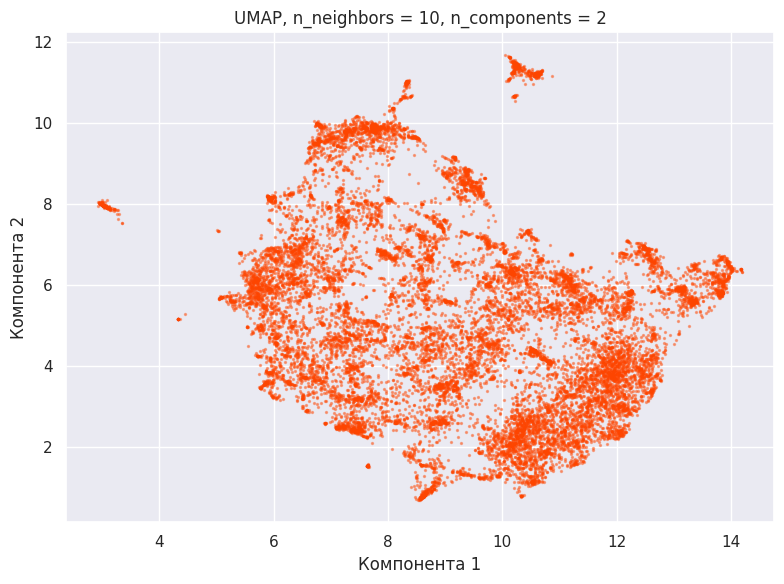

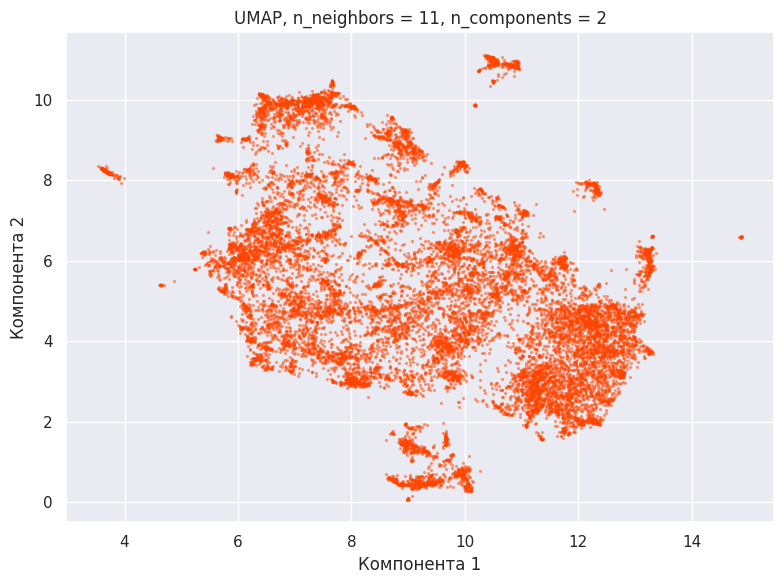

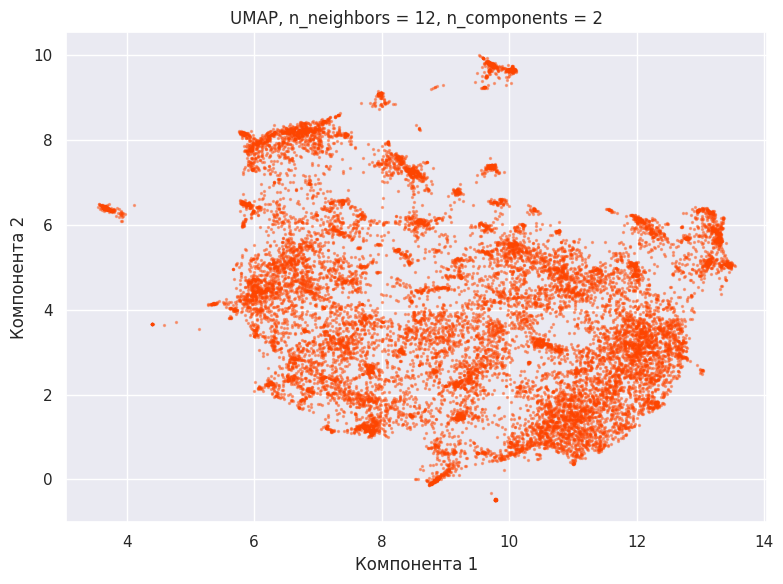

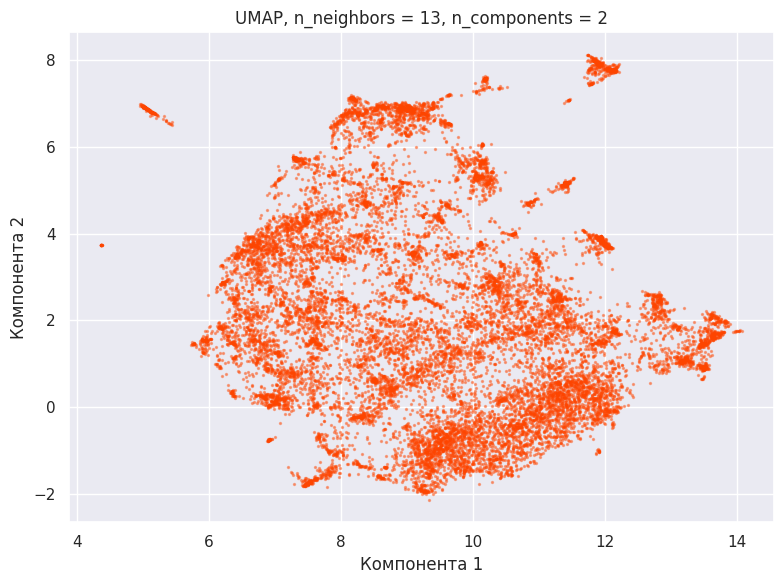

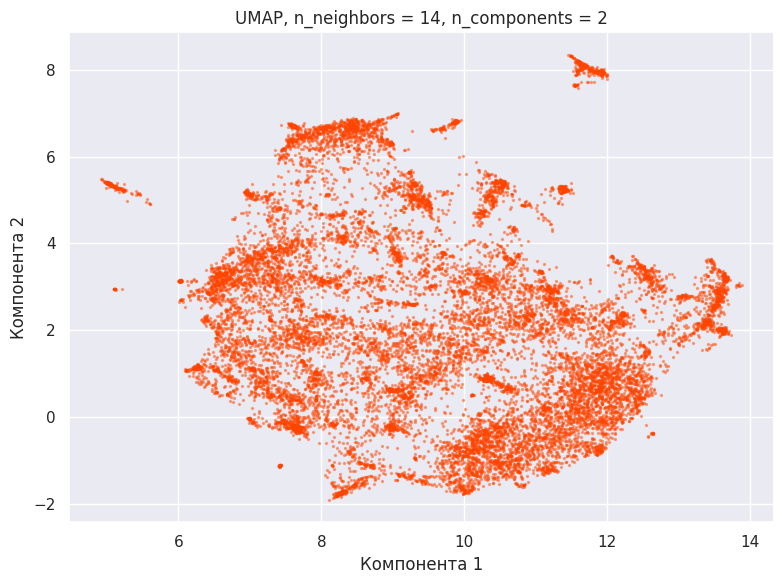

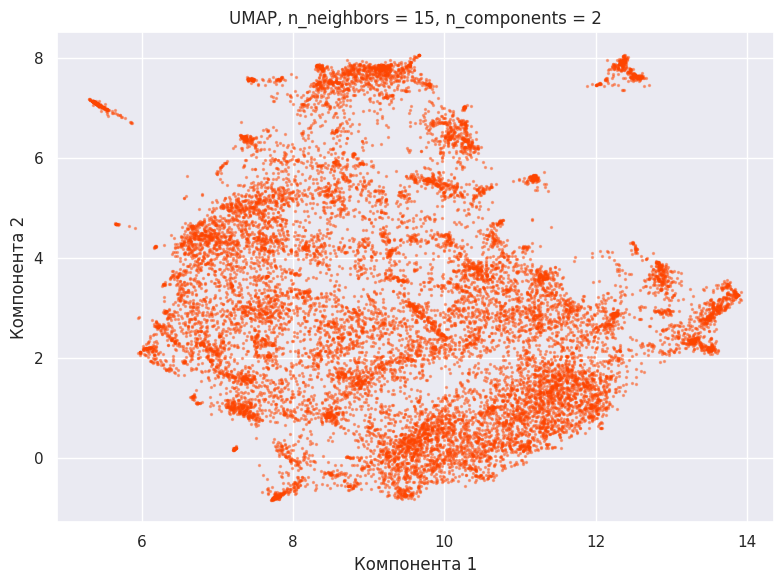

In [78]:
neighbors_list = np.arange(10, 16, 1)
for neighbors in neighbors_list:
    umap_model = UMAP(
        n_neighbors=neighbors,
        n_components=2,
        min_dist=0.0,
        low_memory=False,
        metric="cosine",
        random_state=100,
    )

    # Применяем UMAP к данным
    umap_result = umap_model.fit_transform(embeddings)

    # Визуализируем результаты
    plt.figure(figsize=(8, 6))
    plt.scatter(umap_result[:, 0], umap_result[:, 1], alpha=0.4, c="orangered", s=2)
    plt.title(f"UMAP, n_neighbors = {neighbors}, n_components = 2")
    plt.xlabel("Компонента 1")
    plt.ylabel("Компонента 2")
    plt.tight_layout()
    plt.show()

#### Разобьем данные на кластеры с помощью HDBSCAN:

In [79]:
from hdbscan import HDBSCAN

#### Покажем результаты кластеризации:

In [80]:
# Уменьшим размерность с помощью UMAP
umap_model = UMAP(
    n_neighbors=15,
    n_components=2,
    min_dist=0.0,
    low_memory=False,
    metric="cosine",
    random_state=100,
)
umap_result = umap_model.fit_transform(embeddings)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

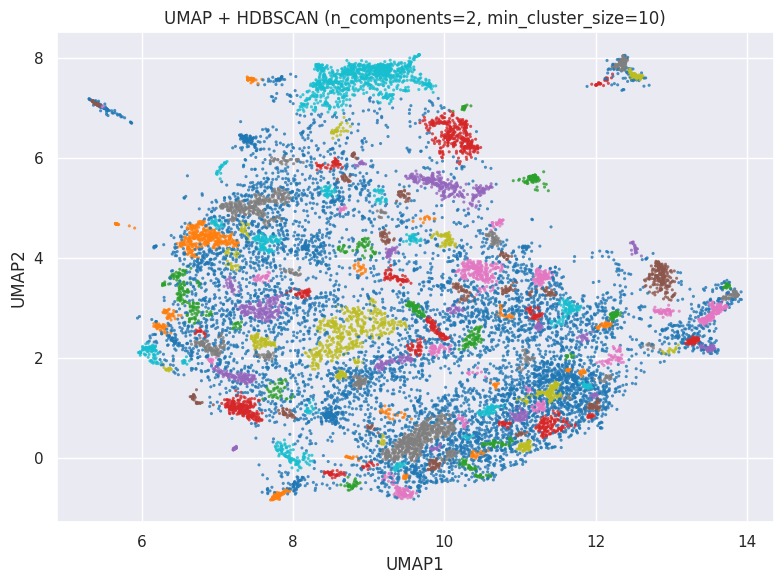

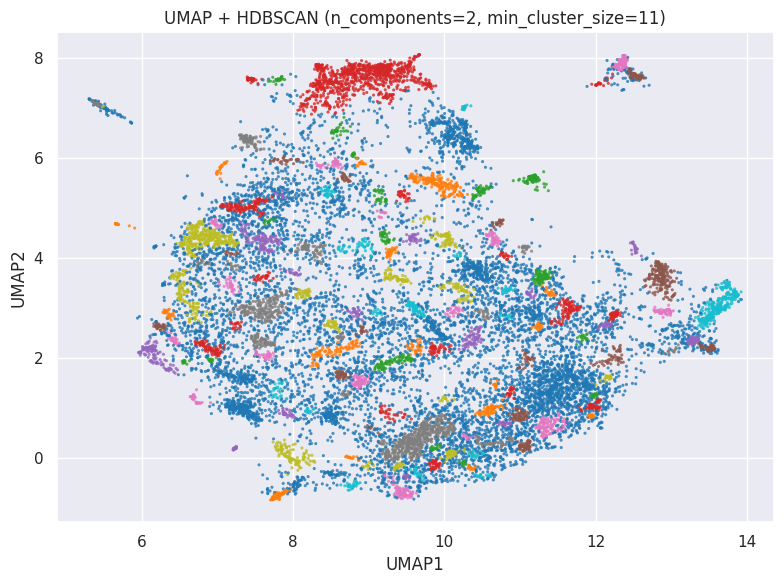

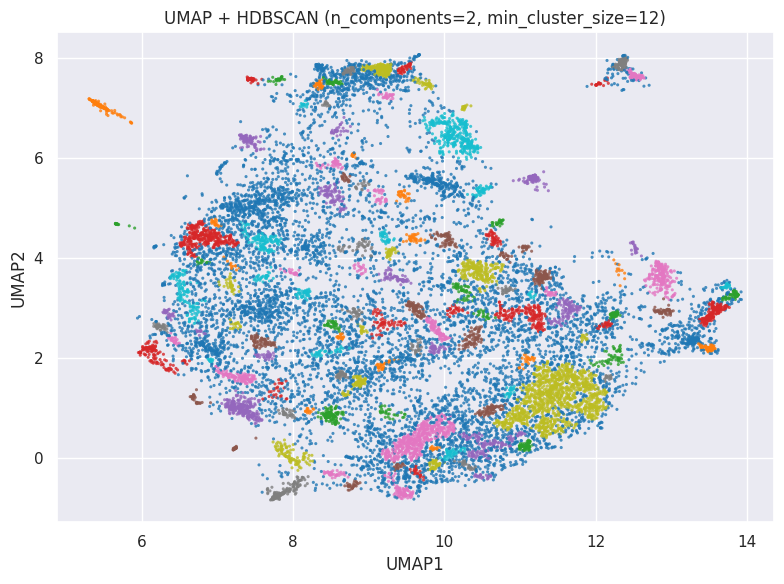

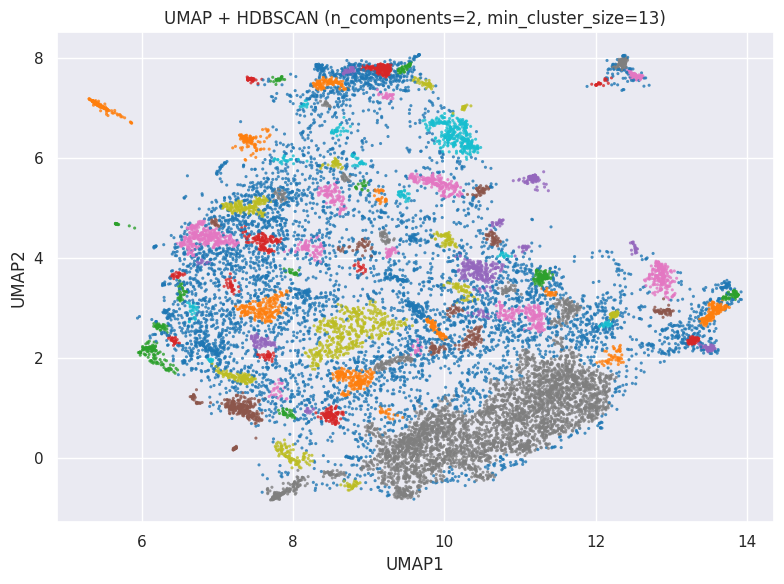

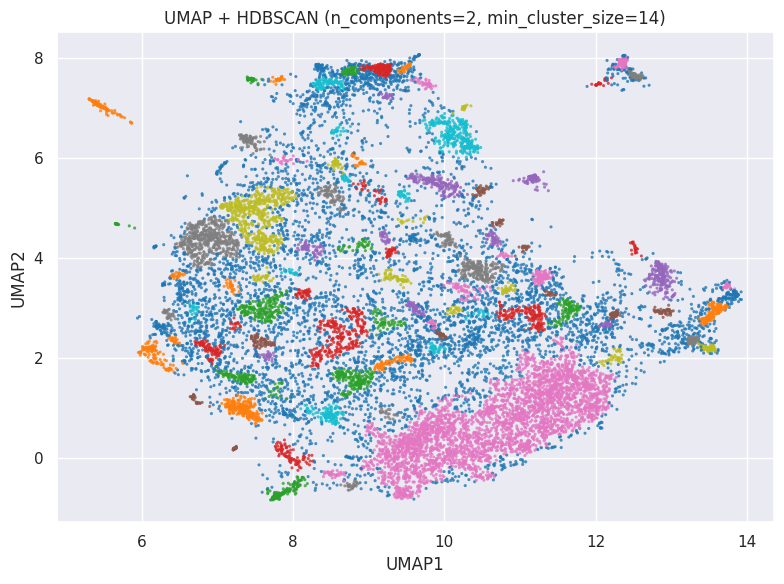

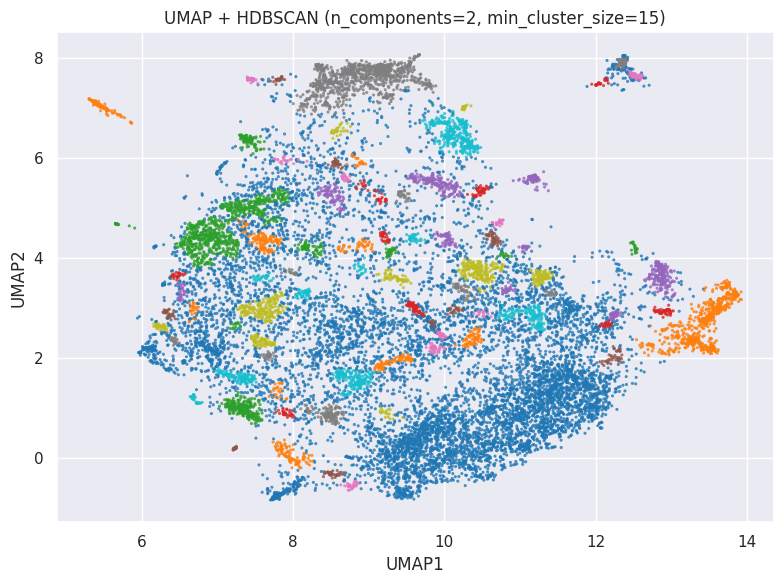

In [156]:
sizes = np.arange(10, 16, 1)
for size in sizes:
    # Кластеризуем данные с помощью HDBSCAN
    hdbscan_model = HDBSCAN(
        min_cluster_size=size, metric="euclidean", prediction_data=True
    )
    hdbscan_labels = hdbscan_model.fit_predict(umap_result)

    # Создадим DataFrame с результатами UMAP и метками HDBSCAN
    df = pd.DataFrame(umap_result, columns=[f"UMAP{i+1}" for i in range(0, 2, 1)])
    df["Cluster"] = hdbscan_labels

    # Рассеянная диаграмма для результатов UMAP
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        x="UMAP1",
        alpha=0.8,
        y="UMAP2",
        hue="Cluster",
        data=df,
        palette="tab10",
        legend=None,
        linewidth=0,
        s=5,
    ).set_title(f"UMAP + HDBSCAN (n_components=2, min_cluster_size={size})")
    plt.tight_layout()
    plt.show()

#### Подставим выбранные гипермараметры для UMAP и HDBSCAN:

Гиперпараметры выбраны с учетом целей:

1. Cохранить локальную структуру данных после уменьшения размерности данных, UMAP
2. Уменьшить количество шума в кластерах, HDBSCAN
3. Создать список понятных тем на выходе

In [82]:
umap_model = UMAP(
    n_neighbors=15,
    n_components=5,
    min_dist=0.0,
    low_memory=False,
    metric="cosine",
    random_state=100,
)
hdbscan_model = HDBSCAN(min_cluster_size=15, metric="euclidean", prediction_data=True)

#### Удалим стоп-слова после распределения текстов по темам:

In [83]:
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS

In [84]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer_model = CountVectorizer(
    stop_words=list(spacy_stopwords), min_df=0.03, max_df=0.99, ngram_range=(1, 2)
)

#### Запустим пайплайн и обучим модель:

Модель MaximalMarginalRelevance изменяет порядок слов в темах, чтобы убрать смысловые повторения и составить последовательность из самых значимых слов.

In [102]:
# Создаем модель BERTopic
representation_model = (
    MaximalMarginalRelevance()
)
topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    representation_model=representation_model,
    language="english",
    verbose=True,
    nr_topics="auto"
)

# Обучаем модель
topics, probs = topic_model.fit_transform(clean_data, embeddings)

# Получаем темы
topic_representation = topic_model.get_topic_info()

2024-06-29 20:19:49,704 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-06-29 20:20:04,260 - BERTopic - Dimensionality - Completed ✓
2024-06-29 20:20:04,262 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-06-29 20:20:04,899 - BERTopic - Cluster - Completed ✓
2024-06-29 20:20:04,901 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-06-29 20:20:11,569 - BERTopic - Representation - Completed ✓
2024-06-29 20:20:11,572 - BERTopic - Topic reduction - Reducing number of topics
2024-06-29 20:20:16,939 - BERTopic - Topic reduction - Reduced number of topics from 99 to 77


### Темы:

#### Выведем список тем:

In [103]:
topic_representation["Name"].to_list()

['-1_biden_trump_debate_vote',
 '0_biden_debate_trump_vote',
 '1_night_think_fucked_world',
 '2_congress_supreme court_law_courts',
 '3_vote_voting_election_candidate',
 '4_israel_gaza_palestinians_hamas',
 '5_nyt_editorial board_york times_nyt editorial',
 '6_haley_woman_michelle obama_michelle',
 '7_bernie_hillary_voters_primaries',
 '8_smell_weed_smoke_smells',
 '9_cnn_msnbc_lies_time cnn',
 '10_homeless_housing_homelessness_money',
 '11_whitmer_whitmer newsom_newsom whitmer_gretchen',
 '12_teleprompter_reading_reading teleprompter_speech',
 '13_trump_lies_trump lying_lied',
 '14_democrats_dems_republicans_democratic',
 '15_lies_lie_liar_lying',
 '16_black jobs_hispanic_black people_immigrants',
 '17_abortion_abortions_babies_birth abortion',
 '18_putin_russia_ukraine_nato',
 '19_dementia_age_81 year_cognitive decline',
 '20_joe_step_step aside_joe step',
 '21_newsom_gavin_california_gavin newsom',
 '22_harris_kamala harris_biden harris_voted biden',
 '23_kamala_dies_biden_dems',
 '

#### Покажем темы на графиках:

In [104]:
import plotly.io as pio

pio.renderers.default = "notebook+vscode+jupyterlab"

In [105]:
topic_model.visualize_topics(width=1000, height=1000)

In [106]:
hierarchical_topics = topic_model.hierarchical_topics(clean_data)

100%|██████████| 75/75 [00:05<00:00, 14.34it/s]


In [107]:
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

In [108]:
tree = topic_model.get_topic_tree(hierarchical_topics)

In [109]:
print(tree)

.
├─teleprompter_cold_stutter_dementia_reading teleprompter
│    ├─cold_cold medicine_cough_throat_like cold
│    │    ├─■──cold_biden cold_exactly biden_biden_cold biden ── Topic: 71
│    │    └─cold_cough_cold medicine_coughing_getting cold
│    │         ├─■──cold_cold medicine_cough_getting cold_coughing ── Topic: 34
│    │         └─■──cold_sick_having cold_debate_speech ── Topic: 57
│    └─teleprompter_stutter_dementia_reading teleprompter_speech
│         ├─stutter_dementia_cognitive_stuttering_age
│         │    ├─dementia_sundowning_age_cognitive decline_older
│         │    │    ├─■──sundowning_sun_sun downing_evening_dementia ── Topic: 59
│         │    │    └─■──dementia_age_81 year_cognitive decline_older ── Topic: 19
│         │    └─stutter_stuttering_stutterer_dementia_old stutter
│         │         ├─■──stutter_stuttering_dementia_old stutter_stroke ── Topic: 52
│         │         └─■──stutter_stutterer_stuttering_words_train thought ── Topic: 41
│         └─teleprom

#### Создадим датафрейм с данными:

In [125]:
topics_bert = topic_representation["Name"].to_list()

# Получим текущую дату и время
now = datetime.now()
# Преобразуем их в строку в формате YYYYMMDD
date_str = now.strftime("%Y_%m_%d")

df_bert = pd.DataFrame(data=topic_model.generate_topic_labels(nr_words=None, topic_prefix=False), columns=["topics"])
df_bert["date"] = date_str
df_bert["size"] = df_bert.index
df_bert = df_bert[["date", "size", "topics"]]

In [126]:
def clean_df_bert(df):
    df = re.sub(r"_", ",", df)
    return df

In [127]:
df_bert["topics"] = df_bert["topics"].apply(clean_df_bert)
print(df_bert)

          date  size                                             topics
0   2024_06_29     0  biden,trump,debate,vote,candidate,election,vot...
1   2024_06_29     1  biden,debate,trump,vote,debates,candidate,elec...
2   2024_06_29     2  night,think,fucked,world,gaslighting,happen,ba...
3   2024_06_29     3  congress,supreme court,law,courts,convicted,ju...
4   2024_06_29     4  vote,voting,election,candidate,people vote,vot...
..         ...   ...                                                ...
72  2024_06_29    72  cold,biden cold,exactly biden,biden,cold biden...
73  2024_06_29    73  deleted,overconfident,rude,ad,birds,aback,shy,...
74  2024_06_29    74  vote,shit trump,trump vote,republican,trump,sa...
75  2024_06_29    75  thomas,alito,corruption,wrongly,thomas alito,a...
76  2024_06_29    76  religion,freedom,religious,commandments,freedo...

[77 rows x 3 columns]


### Сохраним результат моделирования за день в формате csv:

In [128]:
def save_dataframe(df):
    # Получим текущую дату и время
    now = datetime.now()

    # Преобразуем их в строку в формате YYYYMMDD
    date_str = now.strftime("%Y_%m_%d")

    # Сохраним DataFrame в CSV-файл с текущей датой в имени файла
    df.to_csv(
        f"result_csvs/{subreddit.display_name}_topics_{date_str}.csv",
        index=False,
    )

In [129]:
save_dataframe(df_bert)

### Сохраним исходные данные в формате csv:

In [153]:
import csv

In [154]:
data_list = []
for doc in clean_data:
    doc = [doc]
    data_list.append(doc)

In [155]:
fields = ['comments'] 
rows = data_list
 
with open(f'data_csvs/{subreddit.display_name}_data_{date_str}.csv', 'w') as f:
    write = csv.writer(f)
    write.writerow(fields)
    write.writerows(rows)

## Выводы

Был построен алгоритм, который собирает данные из открытого источника информации - раздела Politics из форума Reddit, затем извлекает самые обсуждаемые темы с помощью модели BERTopic. С небольшими доработками, можно превратить этот ноутбук в скрипт, который будет запускаться по расписанию и собирать данные. Когда накопиться требуемый обьем данных - можно проводить новые исследования. Например, динамическое тематическое моделирование с целью исследования изменения трендов в обсуждениях со временем.

В работе не представлены метрики для оценки качества модели, т.к. отсутсвие надежных метрик - одна из актуальных проблем в области тематического моделирования. Наилучший результат, который подвержен субьективности, достигается с помощью перебора разных параметров модели. По этой причине, BERTopic выгодно отличается от других решений, т.к. с каждым алгоритмом в модели можно экспериментировать отдельно и не проводить каждый раз полное моделирование. В целом, этот проект направлен на дальнейшую автоматизацию и требует тематическую модель, которая будет показывать понятные темы с минимальной настройкой гиперпараметров, т.к. скрипт для извлечения тем будет запускаться автоматически. BERTopic - единственная на данный момент модель, которая позволяет сделать это.